In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
mnist_train = datasets.FashionMNIST("..\datasets", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST("..\datasets", train=False, download=True, transform=transforms.ToTensor())

In [3]:
def dloaders(batch_size):
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

- 28x28 = 784 pixel values
- 10 classes
- 256 hidden units

## Model parameters

In [4]:
num_inputs = 784
num_outputs = 10
num_hiddens = 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

params =  [W1, b1, W2, b2]

## Activation function
- ``torch.zeros_like`` Returns a tensor filled with the scalar value 0, with the same size as input

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## Model
Because we are disregarding spatial structure, we reshape each two-dimensional image into a flat vector of length num_inputs.

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear): # is model instance of nn.Linear?
        nn.init.normal_(m.weight, std=0.01) # initialize weights with normal distribution
        m.bias.data.fill_(0.01)

In [7]:
def init_model(in_features, out_features, output):
    model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.Linear(out_features, output)
    )
    model.apply(init_weights)
    return model

## Loss function

In [8]:
loss = nn.CrossEntropyLoss()

## Training procedure

In [9]:
train_losses, test_losses = list(), list()
train_accuracies, test_accuracies = list(), list()
# these lists are just for plotting
plt_train_losses, plt_test_losses = list(), list()
plt_train_accuracies, plt_test_accuracies = list(), list() 

def fit(model, train_loader, epochs, learning_rate, loss_func=nn.CrossEntropyLoss(), opt_func=torch.optim.SGD):
    
    train_losses.clear()
    test_losses.clear()
    train_accuracies.clear()
    test_accuracies.clear()
    plt_train_losses.clear()
    plt_test_losses.clear()
    plt_train_accuracies.clear()
    plt_test_accuracies.clear() 
    
    loss = loss_func # computes softmax and then the cross entropy
    optimizer = opt_func(model.parameters(), learning_rate) # objective function
    
    for epoch in range(epochs):
        
        
        # --Training Phase--
        
        for i, (x_batch, y_batch) in enumerate(train_loader):

            # 1. forward
            y_hat = model(x_batch) # logits

            # 2. compute objective function (softmax, cross entropy)
            l = loss(y_hat, y_batch)

            # 3. cleaning gradients
            optimizer.zero_grad() # params.grad_zero_()

            # 4. accumulate partial derivatives
            l.backward() #params.grad.add_(dJ/dparams)

            # 5. step in the opposite direction of the gradient
            optimizer.step() # with torch.no_grad(): params = params - lr * params.grad
            
            # metrics
            train_losses.append(l.item())
            acc = accuracy(y_hat, y_batch)
            train_accuracies.append(acc)
        
        # just for plotting
        plt_train_accuracies.append(torch.tensor(train_accuracies).mean())
        plt_train_losses.append(torch.tensor(train_losses).mean())
        
        print(f'Epoch {epoch + 1}', end=', ') 
        print(f'training loss = {torch.tensor(train_losses).mean():.2f}', end=', ')
        print(f'training accuracy = {torch.tensor(train_accuracies).mean():.2f}')
        
        
        # --Validation Phase--
        
        for i, (x_batch, y_batch) in enumerate(test_loader):
            
            with torch.no_grad():
                y_hat = model(x_batch)
            
            l = loss(y_hat, y_batch)
            
            test_losses.append(l.item())
            acc = accuracy(y_hat, y_batch)
            test_accuracies.append(acc)
        
        # just for plotting
        plt_test_accuracies.append(torch.tensor(test_accuracies).mean())
        plt_test_losses.append(torch.tensor(test_losses).mean())
        
        print(f'Epoch {epoch + 1}', end=', ') 
        print(f'test loss = {torch.tensor(test_losses).mean():.2f}', end=', ')
        print(f'test accuracy = {torch.tensor(test_accuracies).mean():.2f}')

## Accuracy

In [10]:
def accuracy(y_hat, y):
    _, predictions = torch.max(y_hat, dim=1) # single class with highest probability. simply retain indices
    correct = (predictions == y).float()
    accuracy = correct.sum() / len(predictions) # same as .mean()
    accuracy = torch.round(accuracy * 100)
    return accuracy

## Prediction

In [11]:
def predict(model, test_loader):
    wrong = 0
    correct = 0
    for X, y in test_loader:
        trues = y
        preds = model(X).argmax(axis=1)
        for true, pred in zip(trues, preds):
            if true != pred:
                wrong += 1
            else:
                correct += 1
    print(f'Correct classified: {correct}')
    print(f'Wrong classified: {wrong}')
    print(f'Total Accuracy: {correct / (correct + wrong) * 100}')

## Training

In [12]:
epochs = 10
learning_rate = 0.1
updater = torch.optim.SGD(params, lr=learning_rate)
batch_size = 50

In [13]:
train_loader, test_loader = dloaders(batch_size=batch_size)
model = init_model(in_features=28*28, out_features=256, output=10)
fit(model, train_loader, epochs, learning_rate) # training

Epoch 1, training loss = 0.65, training accuracy = 76.86
Epoch 1, test loss = 0.48, test accuracy = 82.62
Epoch 2, training loss = 0.54, training accuracy = 80.71
Epoch 2, test loss = 0.46, test accuracy = 83.06
Epoch 3, training loss = 0.49, training accuracy = 82.48
Epoch 3, test loss = 0.45, test accuracy = 83.42
Epoch 4, training loss = 0.46, training accuracy = 83.64
Epoch 4, test loss = 0.43, test accuracy = 84.17
Epoch 5, training loss = 0.43, training accuracy = 84.46
Epoch 5, test loss = 0.42, test accuracy = 84.60
Epoch 6, training loss = 0.41, training accuracy = 85.08
Epoch 6, test loss = 0.41, test accuracy = 84.85
Epoch 7, training loss = 0.40, training accuracy = 85.58
Epoch 7, test loss = 0.41, test accuracy = 85.15
Epoch 8, training loss = 0.39, training accuracy = 86.01
Epoch 8, test loss = 0.40, test accuracy = 85.31
Epoch 9, training loss = 0.38, training accuracy = 86.38
Epoch 9, test loss = 0.40, test accuracy = 85.52
Epoch 10, training loss = 0.37, training accur

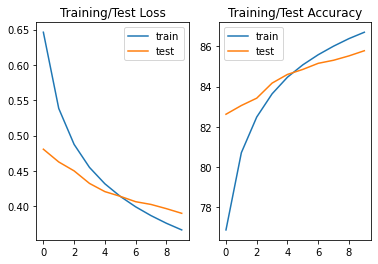

In [14]:
# Losses
plt.subplot(1, 2, 1)
plt.plot(plt_train_losses, label='train')
plt.plot(plt_test_losses, label='test')
plt.legend()
plt.title('Training/Test Loss')

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(plt_train_accuracies, label='train')
plt.plot(plt_test_accuracies, label='test')
plt.legend()
plt.title('Training/Test Accuracy')

plt.show()

In [15]:
predict(model, test_loader)

Correct classified: 8809
Wrong classified: 1191
Total Accuracy: 88.09
